# Higgs Challenge Example using Neural Networks -- continued


### Load the data and preprocessing

In [1]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')

In [3]:
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1})

In [4]:
# let's create separate arrays
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [5]:
#now split into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

We will again use the [approximate median significance][1] from the Kaggle competition to determine how good a solution was. Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the total yield, which we will do below.

[1]: AMS.ipynb

In [8]:
# load function to compute approximate median significance (AMS)
%pycat ams.py
%run ams.py

In [11]:
# calculate the total weights (yields)
sigall  = weight.dot(y)
backall = weight.dot(y == 0)

sigtrain  = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

sigtest  = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)



## Rescaling
Neural networks are quite sensitive to feature scaling, so let's try to scale the features.

In [9]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neutral networks with Keras
SciKit Learn has simple NNs, but if you want to do deep NNs, or train on GPUs, you probably want to use something like Keras instead. 

Let's try to create a deep NN using Keras.

In [6]:
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization


/home/gduckeck/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# create the model
from keras import regularizers

model = Sequential()
model.add(Dense(units = 100, input_shape=(30,)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(units = 100))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(units = 100))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(units =   1, activation='sigmoid'))

* `Dense`: "Just your regular densely-connected NN layer."
  * implements the operation: output = activation(dot(input, kernel) + bias)
    * kernel is a weights matrix created by the layer
    * bias is a bias vector created by the layer (only applicable if `use_bias` is True)
  * `units`: dimensionality of the output array
  * `input_shape`: expected shape of the input arrays (only needed for first layer)
  * `activation`: element-wise activation function
  * `kernel_regularizer`: constraint function applied to the kernel weights matrix (see [constraints][1])
  
  
[1]: https://keras.io/constraints/

In [ ]:
# visualize model -- output to file
#from keras.utils import plot_model
#plot_model(model)

In [ ]:
# visualize model -- inline (need pydot, graphviz and pydotplus)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

* `optimizer`: name of optimizer or optimizer instance. See [optimizers][1].
  * _Adam_: an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments ([paper][2], a short [summary][4])
* `loss`: name of objective function or objective function. See [losses][3].
  * _binary crossentropy_: 
    $$H_p(q) = -\frac{1}{N}\sum_{i=1}^N [{y_i} \log(\hat{y}_i)+(1-y_i) \log(1-\hat{y}_i)]$$
    * a measure of dissimilarity, used here to define the loss function that should be minimized: "The cross entropy between two probability distributions p and q over the same underlying set of events measures the average number of bits needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution q, rather than the true distribution p."
       * here the true labels are $y_i=1$ for the positive class and $y_i=0$ for the negative class
       * the estimated probabilities are $\hat y_{i}$
       * $N$ runs over all samples
* `metrics`: list of metrics to be evaluated by the model during training and testing (typically accuracy)

[1]: https://keras.io/optimizers/
[2]: https://arxiv.org/abs/1412.6980v8
[3]: https://keras.io/losses/
[4]: https://medium.com/@nishantnikhil/adam-optimizer-notes-ddac4fd7218

In [12]:
class_weight = {0: y_train.shape[0]/backtrain, 1:y_train.shape[0]/sigtrain}
class_weight

{0: 1.9909186536998906, 1: 1182.3150708555781}

In [13]:
weight_train_tot = np.array(weight_train*np.array(list(class_weight.values()))[y_train.astype(int)])
weight_test_tot = np.array(weight_test*np.array(list(class_weight.values()))[y_test.astype(int)])
weight_train_tot /= weight_train_tot.mean()
weight_test_tot /= weight_test_tot.mean()

In [14]:
# train Keras NN (much faster than the MLP)
#model.fit(X_train_scaled, y_train, epochs=5, batch_size=128, sample_weight=weight_train)
from keras.callbacks import EarlyStopping
#history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=weight_train_tot,
#                    validation_data=[X_test_scaled, y_test, weight_test_tot],
#                    callbacks=[EarlyStopping(verbose=True, patience=3, restore_best_weights=True)])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=weight_train_tot,
                    validation_data=[X_test_scaled, y_test, weight_test_tot],
                    callbacks=[EarlyStopping(verbose=True, patience=3)])

Train on 548219 samples, validate on 270019 samples
Epoch 1/100
548219/548219 [==============================] - 45s 82us/step - loss: 0.3528 - acc: 0.7600 - val_loss: 0.3355 - val_acc: 0.7726
Epoch 2/100
548219/548219 [==============================] - 46s 83us/step - loss: 0.3407 - acc: 0.7694 - val_loss: 0.3288 - val_acc: 0.7767
Epoch 3/100
548219/548219 [==============================] - 45s 82us/step - loss: 0.3368 - acc: 0.7728 - val_loss: 0.3296 - val_acc: 0.7586
Epoch 4/100
548219/548219 [==============================] - 44s 80us/step - loss: 0.3347 - acc: 0.7745 - val_loss: 0.3295 - val_acc: 0.7690
Epoch 5/100
548219/548219 [==============================] - 44s 81us/step - loss: 0.3333 - acc: 0.7757 - val_loss: 0.3285 - val_acc: 0.7641
Epoch 6/100
548219/548219 [==============================] - 46s 85us/step - loss: 0.3318 - acc: 0.7759 - val_loss: 0.3324 - val_acc: 0.7525
Epoch 7/100
548219/548219 [==============================] - 45s 82us/step - loss: 0.3306 - acc: 0.777

* `batch_size`: number of samples per gradient update
* `epochs`: number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. 


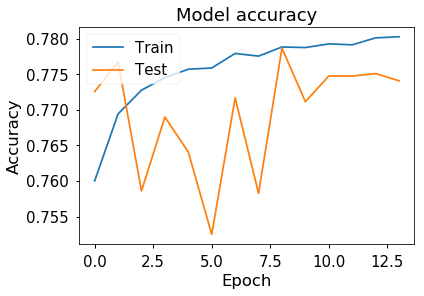

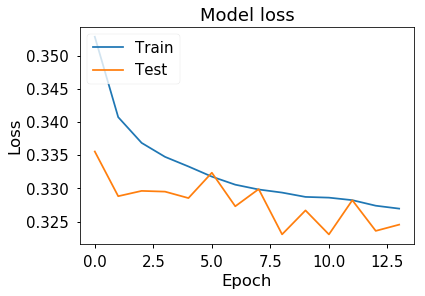

In [15]:
# visualize training history returned by model.fit

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_keras = model.predict(X_train_scaled)[:, 0]
y_test_prob_keras = model.predict(X_test_scaled)[:, 0]
pcut_keras = np.percentile(y_train_prob_keras,85)

In [17]:
# compute and rescale event yields after selection
sigtrain_sel_keras = weight_train.dot(np.multiply(y_train, y_train_prob_keras > pcut_keras))
backtrain_sel_keras = weight_train.dot(np.multiply(y_train == 0, y_train_prob_keras > pcut_keras))

sigtest_sel_keras = weight_test.dot(np.multiply(y_test, y_test_prob_keras > pcut_keras))
backtest_sel_keras = weight_test.dot(np.multiply(y_test == 0, y_test_prob_keras > pcut_keras))

sigtrain_sel_keras_corr = sigtrain_sel_keras*sigall/sigtrain
backtrain_sel_keras_corr = backtrain_sel_keras*backall/backtrain

sigtest_sel_keras_corr = sigtest_sel_keras*sigall/sigtest
backtest_sel_keras_corr = backtest_sel_keras*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_keras_corr, ", background =",backtrain_sel_keras_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_keras_corr, ", background =",backtest_sel_keras_corr)


Corrected selected yields in training sample, signal = 236.87781161202778 , background = 4004.7186159597895
Corrected selected yields in test sample, signal = 238.13876853011783 , background = 4204.250048622709


In [18]:
print("AMS of training sample", ams(sigtrain_sel_keras_corr,backtrain_sel_keras_corr))
print("AMS of test sample", ams(sigtest_sel_keras_corr,backtest_sel_keras_corr))

AMS of training sample 3.7026072212957137
AMS of test sample 3.634583585987848


There are a few things we can easily vary: number of hidden layers, the activation function, the regularization ($\alpha$). 

# Your tasks
Problems (can do with either MLPClassifier or Keras):
1. Vary the structure of the network (number of hidden layers, number of neurons)
1. Vary the activation. (In Keras can do it per layer, in MLPClassifier only for all)
1. Vary the regularization. May have to do this as the structure changes.
1. Try using derivied variables only or primary variables only.
1. Missing data is represented by -999 before scaling. Is there a better value to use in the training?
1. Try using the event weights to better match the background and signal shapes in the training. Note, though, that you should still treat background and signal separately; don't scale the signal down by the weight.